# Log Parsing for Service Tracking Analytics

This notebook parses `output.log` to extract structured data for analysis.
It creates three DataFrames:
1. `df_frames`: Frame-level summary statistics (detections, tracks, etc.).
2. `df_unmatched`: Details of unmatched detections.
3. `df_matches`: Detailed metrics for track-detection matching (IoU, ReID, Fused distance).

In [1]:
import pandas as pd
import re
import os

# Path to the log file
LOG_FILE_PATH = '../output.log'

# Check if file exists
if not os.path.exists(LOG_FILE_PATH):
    print(f"Error: File not found at {LOG_FILE_PATH}")
else:
    print(f"Found log file at {LOG_FILE_PATH}")

Found log file at ../output.log


In [2]:
def parse_log_file(file_path):
    frames_data = []
    unmatched_data = []
    matches_data = []
    
    current_frame = None
    
    # Regex patterns
    # 2025-12-15 20:13:42,644 DEBUG tracker.byte_tracker FRAME 1
    frame_pattern = re.compile(r'FRAME (\d+)')
    
    # total detections: 16 | thresh: 0.6 | high conf: 14 | low: 2
    detections_pattern = re.compile(r'total detections: (\d+) \| thresh: ([\d\.]+) \| high conf: (\d+) \| low: (\d+)')
    
    # is_activated stracks before association: 0 | pending conf: 0 | lost: 0
    stracks_pattern = re.compile(r'is_activated stracks before association: (\d+) \| pending conf: (\d+) \| lost: (\d+)')
    
    # tracks reconfirmed: 0 | refound: 0 | confirmed: 0 | new: 16 | lost: 0 | pending conf: 0 | removed: 0 | scavenged: 0
    tracking_stats_pattern = re.compile(r'tracks reconfirmed: (\d+) \| refound: (\d+) \| confirmed: (\d+) \| new: (\d+) \| lost: (\d+) \| pending conf: (\d+) \| removed: (\d+) \| scavenged: (\d+)')
    
    # unmatched detection: [600 326 636 393] | score: 0.86
    unmatched_pattern = re.compile(r'unmatched detection: \[([\d\s]+)\] \| score: ([\d\.]+)')
    
    # Track 1 vs Detection [601 331 629 396]: IoU dist 0.2237, ReID dist 0.0619, Fused dist 0.0943
    match_pattern = re.compile(r'Track (\d+) vs Detection \[([\d\s]+)\]: IoU dist ([\d\.]+), ReID dist ([\d\.]+), Fused dist ([\d\.]+)')

    with open(file_path, 'r') as f:
        for line in f:
            # Check for Frame header
            frame_match = frame_pattern.search(line)
            if frame_match:
                current_frame = int(frame_match.group(1))
                # Initialize a new frame record
                frames_data.append({'frame': current_frame})
                continue
            
            if current_frame is None:
                continue
                
            # Frame Stats: Detections
            det_match = detections_pattern.search(line)
            if det_match:
                frames_data[-1].update({
                    'total_detections': int(det_match.group(1)),
                    'thresh': float(det_match.group(2)),
                    'high_conf': int(det_match.group(3)),
                    'low_conf': int(det_match.group(4))
                })
                continue

            # Frame Stats: Stracks
            stracks_match = stracks_pattern.search(line)
            if stracks_match:
                frames_data[-1].update({
                    'activated_stracks': int(stracks_match.group(1)),
                    'pending_stracks': int(stracks_match.group(2)),
                    'lost_stracks': int(stracks_match.group(3))
                })
                continue
                
            # Frame Stats: Tracking Updates
            stats_match = tracking_stats_pattern.search(line)
            if stats_match:
                frames_data[-1].update({
                    'reconfirmed': int(stats_match.group(1)),
                    'refound': int(stats_match.group(2)),
                    'confirmed': int(stats_match.group(3)),
                    'new': int(stats_match.group(4)),
                    'lost': int(stats_match.group(5)),
                    'pending_conf': int(stats_match.group(6)),
                    'removed': int(stats_match.group(7)),
                    'scavenged': int(stats_match.group(8))
                })
                continue
                
            # Unmatched Detections
            unmatched_match = unmatched_pattern.search(line)
            if unmatched_match:
                bbox_str = unmatched_match.group(1).split()
                unmatched_data.append({
                    'frame': current_frame,
                    'x1': int(bbox_str[0]),
                    'y1': int(bbox_str[1]),
                    'x2': int(bbox_str[2]),
                    'y2': int(bbox_str[3]),
                    'score': float(unmatched_match.group(2))
                })
                continue
                
            # Matches
            match_match = match_pattern.search(line)
            if match_match:
                bbox_str = match_match.group(2).split()
                matches_data.append({
                    'frame': current_frame,
                    'track_id': int(match_match.group(1)),
                    'det_x1': int(bbox_str[0]),
                    'det_y1': int(bbox_str[1]),
                    'det_x2': int(bbox_str[2]),
                    'det_y2': int(bbox_str[3]),
                    'iou_dist': float(match_match.group(3)),
                    'reid_dist': float(match_match.group(4)),
                    'fused_dist': float(match_match.group(5))
                })
                continue

    return pd.DataFrame(frames_data), pd.DataFrame(unmatched_data), pd.DataFrame(matches_data)

# Run the parser
if os.path.exists(LOG_FILE_PATH):
    df_frames, df_unmatched, df_matches = parse_log_file(LOG_FILE_PATH)
    print("Parsing complete.")
else:
    print("Skipping parsing, file not found.")

Parsing complete.


In [3]:
# Display Frame Summary
if 'df_frames' in locals() and not df_frames.empty:
    print("Frame Summary:")
    display(df_frames.head())
    print(df_frames.info())
else:
    print("No frame data found.")

Frame Summary:


,frame,total_detections,thresh,high_conf,low_conf,activated_stracks,pending_stracks,lost_stracks,reconfirmed,refound,confirmed,new,lost,pending_conf,removed,scavenged
0,1,16,0.6,14,2,0,0,0,0,0,0,16,0,0,0,0
1,2,16,0.6,13,3,0,16,0,0,0,0,0,0,16,0,0
2,3,18,0.6,13,5,0,16,0,0,0,0,2,0,16,0,0
3,4,17,0.6,12,5,0,18,0,0,0,15,0,0,2,1,0
4,5,14,0.6,13,1,15,2,0,14,0,0,0,1,0,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   frame              7500 non-null   int64  
 1   total_detections   7500 non-null   int64  
 2   thresh             7500 non-null   float64
 3   high_conf          7500 non-null   int64  
 4   low_conf           7500 non-null   int64  
 5   activated_stracks  7500 non-null   int64  
 6   pending_stracks    7500 non-null   int64  
 7   lost_stracks       7500 non-null   int64  
 8   reconfirmed        7500 non-null   int64  
 9   refound            7500 non-null   int64  
 10  confirmed          7500 non-null   int64  
 11  new                7500 non-null   int64  
 12  lost               7500 non-null   int64  
 13  pending_conf       7500 non-null   int64  
 14  removed            7500 non-null   int64  
 15  scavenged          7500 non-null   int64  
dtypes: float64(1), int64(15)

In [4]:
# Display Unmatched Detections
if 'df_unmatched' in locals() and not df_unmatched.empty:
    print("\nUnmatched Detections:")
    display(df_unmatched.head())
    print(df_unmatched.describe())
else:
    print("No unmatched detections found.")


Unmatched Detections:


,frame,x1,y1,x2,y2,score
0,1,600,326,636,393,0.86
1,1,139,319,171,377,0.85
2,1,348,342,382,427,0.84
3,1,1298,279,1321,327,0.82
4,1,781,303,801,369,0.79


             frame           x1           y1           x2           y2  \
count  4283.000000  4283.000000  4283.000000  4283.000000  4283.000000   
mean   3455.848938   994.014476   404.827224  1020.179080   467.360728   
std    2108.865562   496.009001    76.681298   494.924421    94.004303   
min       1.000000     0.000000   211.000000     7.000000   261.000000   
25%    1538.000000   582.500000   353.000000   607.500000   411.000000   
50%    3745.000000  1014.000000   407.000000  1041.000000   470.000000   
75%    5194.000000  1353.500000   446.000000  1378.500000   508.000000   
max    7500.000000  1910.000000  1004.000000  1922.000000  1081.000000   

             score  
count  4283.000000  
mean      0.521272  
std       0.108246  
min       0.400000  
25%       0.440000  
50%       0.490000  
75%       0.570000  
max       0.900000  


In [5]:
# Display Matching Metrics
if 'df_matches' in locals() and not df_matches.empty:
    print("\nMatching Metrics:")
    display(df_matches.head())
    print(df_matches.describe())
else:
    print("No matching metrics found.")


Matching Metrics:


,frame,track_id,det_x1,det_y1,det_x2,det_y2,iou_dist,reid_dist,fused_dist
0,6,1,601,331,629,396,0.2237,0.0619,0.0943
1,6,2,172,320,198,379,0.1603,0.0020,0.0336
2,6,3,369,346,403,428,0.1163,0.0039,0.0264
3,6,4,1288,285,1307,332,0.1740,0.0040,0.0380
4,6,5,790,310,811,373,0.0640,0.0010,0.0136


               frame       track_id         det_x1         det_y1  \
count  108385.000000  108385.000000  108385.000000  108385.000000   
mean     3721.973160    2125.555566     924.685768     414.308161   
std      2095.619345    1250.535150     474.671302      70.122006   
min         6.000000       1.000000       0.000000     266.000000   
25%      1933.000000    1129.000000     546.000000     364.000000   
50%      3823.000000    2035.000000     932.000000     414.000000   
75%      5464.000000    3228.000000    1267.000000     460.000000   
max      7500.000000    4279.000000    1910.000000     946.000000   

              det_x2         det_y2       iou_dist      reid_dist  \
count  108385.000000  108385.000000  108385.000000  108385.000000   
mean      957.606560     489.625068       0.148333       0.021171   
std       474.381584      86.352380       0.129094       0.027910   
min        11.000000     311.000000       0.002100       0.000000   
25%       574.000000     426.0000

In [9]:
max_iou_distance = .15
df_low_iou_matches = df_matches[df_matches['iou_dist'] < max_iou_distance]
print(f"\nMatches with IoU distance < {max_iou_distance}:")
if not df_low_iou_matches.empty:
    display(df_low_iou_matches)
    print(df_low_iou_matches.describe())


Matches with IoU distance < 0.15:


,frame,track_id,det_x1,det_y1,det_x2,det_y2,iou_dist,reid_dist,fused_dist
2,6,3,369,346,403,428,0.1163,0.0039,0.0264
4,6,5,790,310,811,373,0.0640,0.0010,0.0136
5,6,6,304,299,324,347,0.0944,0.0124,0.0288
6,6,7,1715,301,1736,350,0.1014,0.0105,0.0287
8,6,9,1137,317,1155,380,0.1018,0.0118,0.0298
...,...,...,...,...,...,...,...,...,...
108374,7500,4098,933,344,997,435,0.0400,0.0101,0.0161
108375,7500,3989,1780,283,1818,379,0.1140,0.0017,0.0241
108377,7500,4200,447,398,543,517,0.0901,0.0023,0.0199
108378,7500,3932,411,412,489,518,0.0397,0.0217,0.0253


              frame      track_id        det_x1        det_y1        det_x2  \
count  71063.000000  71063.000000  71063.000000  71063.000000  71063.000000   
mean    3810.248639   2160.518906    906.365338    410.485555    938.663425   
std     2154.321458   1280.327029    484.565461     72.349628    484.246688   
min        6.000000      1.000000      0.000000    267.000000     15.000000   
25%     1921.500000   1129.000000    521.000000    357.000000    550.000000   
50%     3866.000000   2035.000000    900.000000    408.000000    931.000000   
75%     5649.000000   3355.000000   1259.000000    461.000000   1289.000000   
max     7500.000000   4279.000000   1908.000000    941.000000   1921.000000   

             det_y2      iou_dist     reid_dist    fused_dist  
count  71063.000000  71063.000000  71063.000000  71063.000000  
mean     486.836511      0.080971      0.017877      0.030738  
std       87.197162      0.036713      0.023853      0.021492  
min      313.000000      0.00210

Correlation between IoU Distance and ReID Distance: 0.1987


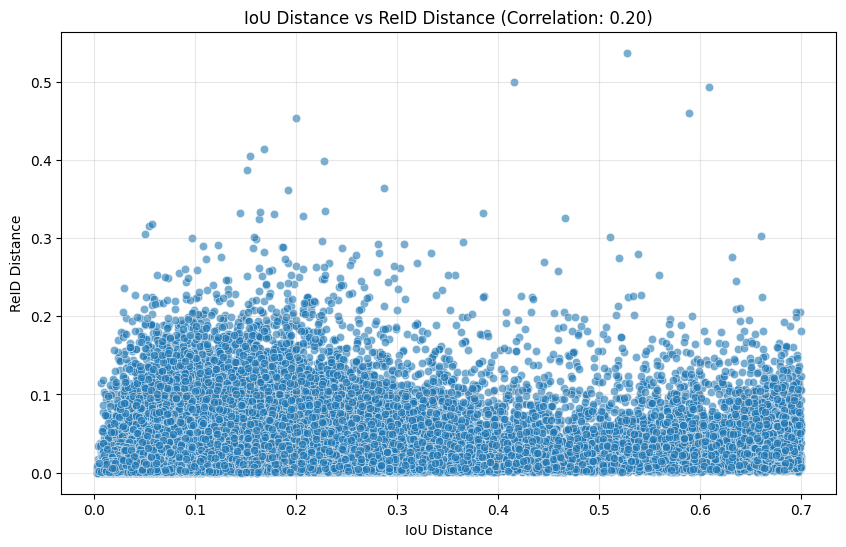

In [11]:
# Correlation Analysis: IoU vs ReID Distance
if 'df_matches' in locals() and not df_matches.empty:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Calculate correlation
    correlation = df_matches['iou_dist'].corr(df_matches['reid_dist'])
    print(f"Correlation between IoU Distance and ReID Distance: {correlation:.4f}")

    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_matches, x='iou_dist', y='reid_dist', alpha=0.6)
    plt.title(f'IoU Distance vs ReID Distance (Correlation: {correlation:.2f})')
    plt.xlabel('IoU Distance')
    plt.ylabel('ReID Distance')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No matching data available for correlation analysis.")

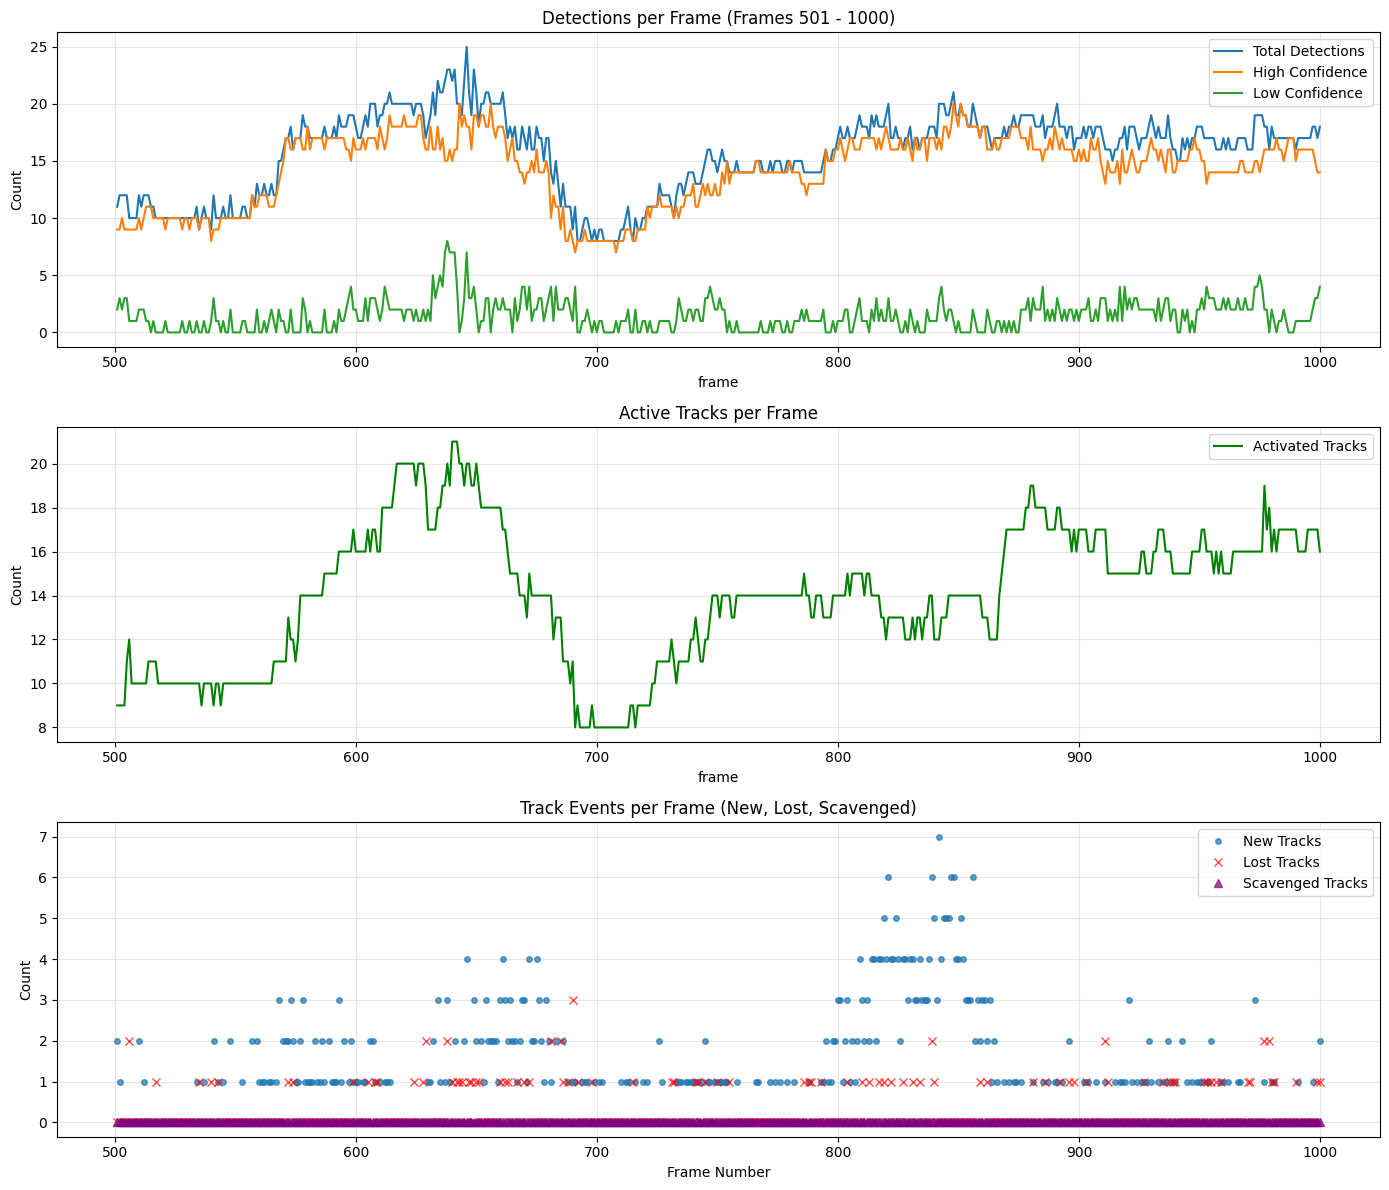

In [16]:
# Chart Frame Statistics Over Time
if 'df_frames' in locals() and not df_frames.empty:
    # Configuration for pagination
    START_FRAME_IDX = 500  # Change this to scroll (e.g., 1000, 2000)
    WINDOW_SIZE = 500
    
    df_subset = df_frames.iloc[START_FRAME_IDX : START_FRAME_IDX + WINDOW_SIZE]
    
    if df_subset.empty:
        print(f"No data in range {START_FRAME_IDX} to {START_FRAME_IDX + WINDOW_SIZE}")
    else:
        plt.figure(figsize=(14, 12))
        
        # Plot Total Detections
        plt.subplot(3, 1, 1)
        sns.lineplot(data=df_subset, x='frame', y='total_detections', label='Total Detections')
        sns.lineplot(data=df_subset, x='frame', y='high_conf', label='High Confidence')
        sns.lineplot(data=df_subset, x='frame', y='low_conf', label='Low Confidence')
        plt.title(f'Detections per Frame (Frames {df_subset["frame"].min()} - {df_subset["frame"].max()})')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot Active Tracks
        plt.subplot(3, 1, 2)
        sns.lineplot(data=df_subset, x='frame', y='activated_stracks', label='Activated Tracks', color='green')
        plt.title('Active Tracks per Frame')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot Track Events (New, Lost, Scavenged)
        plt.subplot(3, 1, 3)
        # Use scatter or markers for sparse events to make them visible
        plt.plot(df_subset['frame'], df_subset['new'], label='New Tracks', marker='o', linestyle='None', markersize=4, alpha=0.7)
        plt.plot(df_subset['frame'], df_subset['lost'], label='Lost Tracks', marker='x', linestyle='None', markersize=6, color='red', alpha=0.7)
        
        if 'scavenged' in df_subset.columns:
            plt.plot(df_subset['frame'], df_subset['scavenged'], label='Scavenged Tracks', marker='^', linestyle='None', markersize=6, color='purple', alpha=0.7)
        
        plt.title('Track Events per Frame (New, Lost, Scavenged)')
        plt.xlabel('Frame Number')
        plt.ylabel('Count')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
else:
    print("No frame data available for charting.")

In [17]:
scavanged_df = df_frames[df_frames['scavenged'] > 0]
print("\nFrames with Scavenged Tracks:")
if not scavanged_df.empty:
    display(scavanged_df)


Frames with Scavenged Tracks:
